In [5]:
# !pip install transformers==4.18.0
# !pip install datasets
# !wget https://raw.githubusercontent.com/gorokoba560/norm-analysis-of-transformer/5dc8fb3b541f696288dec46fbd610d97a1a1ade2/emnlp2021/transformers/src/transformers/modeling_bert.py

## Setup

In [36]:
import torch
import numpy as np
from transformers import BertTokenizer
from datasets import load_dataset
from tqdm.notebook import tqdm
from importlib import reload
import pickle
import lzma
import yaml
# from transformers import BertForSequenceClassification


SELECTED_GPU = 0
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:{}".format(SELECTED_GPU))
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(SELECTED_GPU))
else:
    device = "cpu"

ATTENTION_NORM_TYPES = {
#     "head_attn_n": 0,
    "N": 1,
    "N-Res": 2,
    "N-ResLN": 3,
    "N-Enc": 4
#     "attn_n_ratio": 5,
#     "attnres_n_ratio": 6,
#     "attnresln_n_ratio": 7
#     "N-Enc_ratio": 8
}

class FlowMethods:
    ROLLOUT = "rollout"
    MAX_FLOW = "maxflow"

with open('../src/configs/experiments_config.yaml', "r") as f:
    config = yaml.safe_load(f)
    
### Editable:
config = config["HATEXPLAIN"]  # [SST2, MNLI, HATEXPLAIN] (Load different experiments config i.e. model, dataset and more)

config["FLOW_METHOD"] = FlowMethods.ROLLOUT
config["NUM_CPUS"] = 12  # If n<2 ? sequential : use p_map
config["OUTPUT_HIDDEN_STATES"] = True  # Default: True (Outputs flow up to each layer)
config["DATASET_SIZE_LIMIT"] = None  # Default: None (no limit)
config["DELETE_SEP"] = False  # Default: False (Visualizations will not work if set to True)

config

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


{'MODEL_CHECKPOINT': 'TehranNLP-org/bert-base-uncased-cls-hatexplain',
 'MODEL_NAME': 'bert-base-uncased',
 'DATASET': 'hatexplain',
 'SALIENCY_BLANK_OUT_PATH': '../src/gradients/hatexplain_val_sals_normbased_selfFT.npy',
 'SALS_MAX_LENGTH': 72,
 'FLOW_METHOD': 'rollout',
 'NUM_CPUS': 12,
 'OUTPUT_HIDDEN_STATES': True,
 'DATASET_SIZE_LIMIT': None,
 'DELETE_SEP': False}

## Model/Tokenizer/Dataset

In [37]:
import src.modeling.modeling_bert
reload(src.modeling.modeling_bert)
import src.task_loaders
reload(src.task_loaders)

tokenizer = BertTokenizer.from_pretrained(config["MODEL_NAME"])
model = src.modeling.modeling_bert.BertForSequenceClassification.from_pretrained(
    config["MODEL_CHECKPOINT"], 
    local_files_only=False)
task_loader = src.task_loaders.TaskLoader(tokenizer, count=config["DATASET_SIZE_LIMIT"], 
                                          max_length=config["SALS_MAX_LENGTH"])

dataset, encoder_func = task_loader.load_task(config["DATASET"])

Downloading:   0%|          | 0.00/796 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Reusing dataset hatexplain (C:\Users\Mohsen\.cache\huggingface\datasets\hatexplain\plain_text\1.0.0\df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249)


0ex [00:00, ?ex/s]

## Extract Attentions

In [38]:
import src.model_attentions
reload(src.model_attentions)

raw_attentions, norms_list = src.model_attentions.extract_attentions(model, encoder_func, len(dataset), device, 
                                                                     config["DELETE_SEP"])
print(raw_attentions[-1].shape, norms_list[3][-1].shape)

  0%|          | 0/1922 [00:00<?, ?it/s]

(12, 9, 9) (12, 9, 9)


In [39]:
import src.model_attentions
reload(src.model_attentions)

r_ratio_attentions = src.model_attentions.build_ratio_residual_attentions(raw_attentions, norms_list)
r_ratio_attentions.keys()

  0%|          | 0/1922 [00:00<?, ?it/s]

dict_keys(['W-FixedRes', 'W-Res', 'N-FixedRes', 'Uniform-Res'])

## Compute Attention Rollout/MaxFlow

In [40]:
import src.attention_flow_abstract
reload(src.attention_flow_abstract)
import src.attention_rollout
reload(src.attention_rollout)
import src.attention_max_flow
reload(src.attention_max_flow)

flow_class = src.attention_rollout.AttentionRollout() if config["FLOW_METHOD"] == FlowMethods.ROLLOUT else src.attention_max_flow.AttentionMaxFlow()
flow_function = flow_class.compute_flows
print(flow_function)

attention_flows = dict()

# a = flow_function(raw_attentions[:2], add_fixed_residual=True, desc="raw".ljust(11, '_'), num_cpus=NUM_CPUS)

local_attentions = {"W": raw_attentions}
for key, attention_mat in r_ratio_attentions.items():
    local_attentions[key] = attention_mat
for key, value in ATTENTION_NORM_TYPES.items():
    local_attentions[key] = norms_list[value]
    

for key, local_attention in local_attentions.items():
    attention_flows[key] = flow_function(local_attention, 
                                         desc=key.ljust(12, '_'),
                                         output_hidden_states = config["OUTPUT_HIDDEN_STATES"],
                                         num_cpus=config["NUM_CPUS"])    

# file_name = f"{DATASET}_{MODEL_CHECKPOINT.split('/')[-1]}_{FLOW_METHOD}.pickle_lzma"
# with lzma.open(file_name, 'wb') as f:
#     print("Saving...")
#     pickle.dump(attention_flows, f, protocol=pickle.HIGHEST_PROTOCOL)
#     print(f"Saved attentions to [{file_name}]")
    
print(attention_flows.keys(), attention_flows["N"][-1].shape)

<bound method AttentionRollout.compute_flows of <src.attention_rollout.AttentionRollout object at 0x000001DF6589EEB8>>


W___________:   0%|          | 0/1922 [00:00<?, ?it/s]

W-FixedRes__:   0%|          | 0/1922 [00:00<?, ?it/s]

W-Res_______:   0%|          | 0/1922 [00:00<?, ?it/s]

N-FixedRes__:   0%|          | 0/1922 [00:00<?, ?it/s]

Uniform-Res_:   0%|          | 0/1922 [00:00<?, ?it/s]

N___________:   0%|          | 0/1922 [00:00<?, ?it/s]

N-Res_______:   0%|          | 0/1922 [00:00<?, ?it/s]

N-ResLN_____:   0%|          | 0/1922 [00:00<?, ?it/s]

N-Enc_______:   0%|          | 0/1922 [00:00<?, ?it/s]

dict_keys(['W', 'W-FixedRes', 'W-Res', 'N-FixedRes', 'Uniform-Res', 'N', 'N-Res', 'N-ResLN', 'N-Enc']) (12, 9, 9)


## Compute Metrics (Compare to saliency)

### Flow Correlation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import src.metrics
reload(src.metrics)

# spearmans_raw_flow = src.metrics.compute_spearman_correlation(raw_attentions_rollouts, 
#                                                          SALIENCY_BLANK_OUT_PATH)

spearmans = dict()  # spearmans[key]: (#batch, #layers, spearman)
for key in attention_flows.keys():
    spearmans[key] = src.metrics.compute_spearman_correlation(attention_flows[key], 
                                                              config["SALIENCY_BLANK_OUT_PATH"],
                                                              aggregation="CLS",
                                                              desc=key.ljust(12, '_'),
                                                              max_length=config["SALS_MAX_LENGTH"])


# PRINT
for key in spearmans.keys():
    spearman = np.array(spearmans[key])
    max_layer = np.argmax(np.mean(spearman, axis=0))
#     print(f"Max Layer: {max_layer+1}", f"{key}", f"{np.mean(spearman[:, max_layer]):.2f}", f"± {np.std(spearman[:, max_layer]):.2f}")
    layers = spearmans[key][0].shape[0]
    for layer in range(layers):
        spearman = np.array(spearmans[key])[:, layer]
        layer_text = f"-L{layer+1}" if layers > 1 else ""
        print(f"{key}{layer_text}".ljust(23), f"{np.mean(spearman):.2f}", f"± {np.std(spearman):.2f}")

W___________:   0%|          | 0/1922 [00:00<?, ?it/s]

W-FixedRes__:   0%|          | 0/1922 [00:00<?, ?it/s]

W-Res_______:   0%|          | 0/1922 [00:00<?, ?it/s]

N-FixedRes__:   0%|          | 0/1922 [00:00<?, ?it/s]

Uniform-Res_:   0%|          | 0/1922 [00:00<?, ?it/s]

N___________:   0%|          | 0/1922 [00:00<?, ?it/s]

N-Res_______:   0%|          | 0/1922 [00:00<?, ?it/s]

N-ResLN_____:   0%|          | 0/1922 [00:00<?, ?it/s]

N-Enc_______:   0%|          | 0/1922 [00:00<?, ?it/s]

In [ ]:
# PLOT
fig = plt.figure(figsize=(6, 4))
cmap = plt.get_cmap("tab10")
markers = ['D', 'o', '^', '*', 's', '+', 'x', '.', 'X']
c = 0
for key in spearmans.keys():
    if key in ["N-ResLN", "W-FixedRes", "N-FixedRes", "Uniform-Res"]:
        continue
    layers = spearmans[key][0].shape[0]
    spearman = np.array(spearmans[key])
#     print(np.sqrt(len(spearman)))
    with plt.style.context("ggplot"):
        x = range(1, layers + 1)
        plt.plot(x, np.mean(spearman, axis=0), markers[c], label=key, color=cmap(c))
        plt.plot(x, np.mean(spearman, axis=0), color=cmap(c))
        plt.fill_between(x, 
                         np.mean(spearman, axis=0) - np.std(spearman, axis=0) * 2.575 / np.sqrt(len(spearman)), 
                         np.mean(spearman, axis=0) + np.std(spearman, axis=0) * 2.575 / np.sqrt(len(spearman)),
                         alpha=0.2, color=cmap(c))
        plt.xticks(x)
        
    c += 1
plt.legend(loc="upper left")
dataset_name_map = {"sst2": "SST2", "mnli": "MNLI", "hatexplain": "HATEXPLAIN"}
plt.title(f"Aggregated Attribution Spearman Rank Correlation on {dataset_name_map[config['DATASET']]} Dataset", fontsize=11)
plt.ylabel("Spearman Rank Correlation")
plt.xlabel("Layer")
fig.tight_layout()
# filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
file_name = f"{config['DATASET']}_{config['MODEL_CHECKPOINT'].split('/')[-1]}_{config['FLOW_METHOD']}_spearman.pdf"
fig.savefig(file_name, dpi=50)

In [15]:
local_attentions["W"][0].shape

(12, 12, 12)

### Single Layers Correlation

W 0___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 0__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 0_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 0__:   0%|          | 0/872 [00:00<?, ?it/s]

N 0___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 0_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 0_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 0_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 1___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 1__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 1_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 1__:   0%|          | 0/872 [00:00<?, ?it/s]

N 1___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 1_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 1_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 1_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 2___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 2__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 2_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 2__:   0%|          | 0/872 [00:00<?, ?it/s]

N 2___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 2_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 2_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 2_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 3___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 3__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 3_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 3__:   0%|          | 0/872 [00:00<?, ?it/s]

N 3___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 3_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 3_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 3_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 4___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 4__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 4_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 4__:   0%|          | 0/872 [00:00<?, ?it/s]

N 4___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 4_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 4_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 4_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 5___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 5__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 5_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 5__:   0%|          | 0/872 [00:00<?, ?it/s]

N 5___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 5_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 5_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 5_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 6___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 6__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 6_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 6__:   0%|          | 0/872 [00:00<?, ?it/s]

N 6___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 6_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 6_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 6_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 7___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 7__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 7_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 7__:   0%|          | 0/872 [00:00<?, ?it/s]

N 7___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 7_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 7_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 7_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 8___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 8__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 8_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 8__:   0%|          | 0/872 [00:00<?, ?it/s]

N 8___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 8_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 8_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 8_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 9___________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 9__:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 9_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 9__:   0%|          | 0/872 [00:00<?, ?it/s]

N 9___________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 9_______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 9_____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 9_______:   0%|          | 0/872 [00:00<?, ?it/s]

W 10__________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 10_:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 10______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 10_:   0%|          | 0/872 [00:00<?, ?it/s]

N 10__________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 10______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 10____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 10______:   0%|          | 0/872 [00:00<?, ?it/s]

W 11__________:   0%|          | 0/872 [00:00<?, ?it/s]

W-FixedRes 11_:   0%|          | 0/872 [00:00<?, ?it/s]

W-Res 11______:   0%|          | 0/872 [00:00<?, ?it/s]

N-FixedRes 11_:   0%|          | 0/872 [00:00<?, ?it/s]

N 11__________:   0%|          | 0/872 [00:00<?, ?it/s]

N-Res 11______:   0%|          | 0/872 [00:00<?, ?it/s]

N-ResLN 11____:   0%|          | 0/872 [00:00<?, ?it/s]

N-Enc 11______:   0%|          | 0/872 [00:00<?, ?it/s]

Max Layer: 5 W 0.31 ± 0.23
1 W            -0.52 ± 0.17
2 W            -0.40 ± 0.22
3 W            -0.16 ± 0.26
4 W            0.12 ± 0.26
5 W            0.31 ± 0.23
6 W            0.17 ± 0.25
7 W            0.11 ± 0.25
8 W            0.12 ± 0.25
9 W            0.08 ± 0.23
10 W           0.14 ± 0.23
11 W           0.05 ± 0.24
12 W           0.14 ± 0.25
Max Layer: 5 W-FixedRes 0.32 ± 0.23
1 W-FixedRes   -0.52 ± 0.17
2 W-FixedRes   -0.40 ± 0.22
3 W-FixedRes   -0.16 ± 0.26
4 W-FixedRes   0.13 ± 0.25
5 W-FixedRes   0.32 ± 0.23
6 W-FixedRes   0.18 ± 0.26
7 W-FixedRes   0.14 ± 0.26
8 W-FixedRes   0.14 ± 0.25
9 W-FixedRes   0.13 ± 0.23
10 W-FixedRes  0.17 ± 0.24
11 W-FixedRes  0.08 ± 0.25
12 W-FixedRes  0.17 ± 0.25
Max Layer: 5 W-Res 0.32 ± 0.23
1 W-Res        -0.52 ± 0.17
2 W-Res        -0.40 ± 0.22
3 W-Res        -0.16 ± 0.26
4 W-Res        0.13 ± 0.25
5 W-Res        0.32 ± 0.23
6 W-Res        0.18 ± 0.26
7 W-Res        0.14 ± 0.26
8 W-Res        0.14 ± 0.25
9 W-Res        0.13 ± 0.23
10 W-R

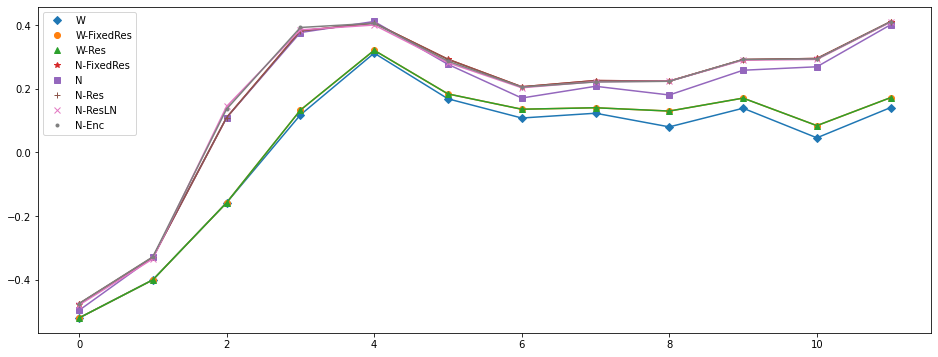

In [19]:
import src.metrics
reload(src.metrics)

spearmans_attentions = dict()
for key, value in local_attentions.items():
    spearmans_attentions[key] = []

for layer in range(12):
    for key, value in local_attentions.items():
        spearmans_attentions[key].append(src.metrics.compute_spearman_correlation([n[layer] for n in local_attentions[key]], 
                                                                                  config["SALIENCY_BLANK_OUT_PATH"],
                                                                                  desc=f"{key} {layer}".ljust(14, '_'),
                                                                                  max_length=config["SALS_MAX_LENGTH"]))
#PRINT
for key, value in spearmans_attentions.items():
    spearmans = np.array(spearmans_attentions[key])
    max_layer = np.argmax(np.mean(spearmans_attentions[key], axis=1))
    print(f"Max Layer: {max_layer+1}", f"{key}", f"{np.mean(spearmans_attentions[key][max_layer]):.2f}", f"± {np.std(spearmans_attentions[key][max_layer]):.2f}")
    for layer in range(12):
        print(f"{layer+1} {key}".ljust(14), 
              f"{np.mean(spearmans_attentions[key][layer]):.2f}",
              f"± {np.std(spearmans_attentions[key][layer]):.2f}")

# PLOT
plt.figure(figsize=(16, 6))
cmap = plt.get_cmap("tab10")
markers = ['D', 'o', '^', '*', 's', '+', 'x', '.', 'X']
c = 0
for key, value in spearmans_attentions.items():
    y_mean = []
    y_std = []
    for layer in range(12):
        y_mean.append(np.mean(spearmans_attentions[key][layer]))
        y_std.append(np.std(spearmans_attentions[key][layer]))
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)
    plt.plot(range(12), y_mean, markers[c], label=key, color=cmap(c))
    plt.plot(range(12), y_mean, color=cmap(c))
#     plt.fill_between(range(12), 
#                      y_mean - y_std, 
#                      y_mean + y_std,
#                      alpha=0.2, color=cmap(c))
    c += 1
plt.legend(loc="upper left")

## Visualization

In [21]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_heatmap(norm, tokenized_text, title=""):
    df = pd.DataFrame(norm, columns=tokenized_text, index=tokenized_text)
    sns.heatmap(df,cmap="Reds",square=True)
    plt.title(title)
    plt.gcf().subplots_adjust(bottom=0.2)

### Attention Flow

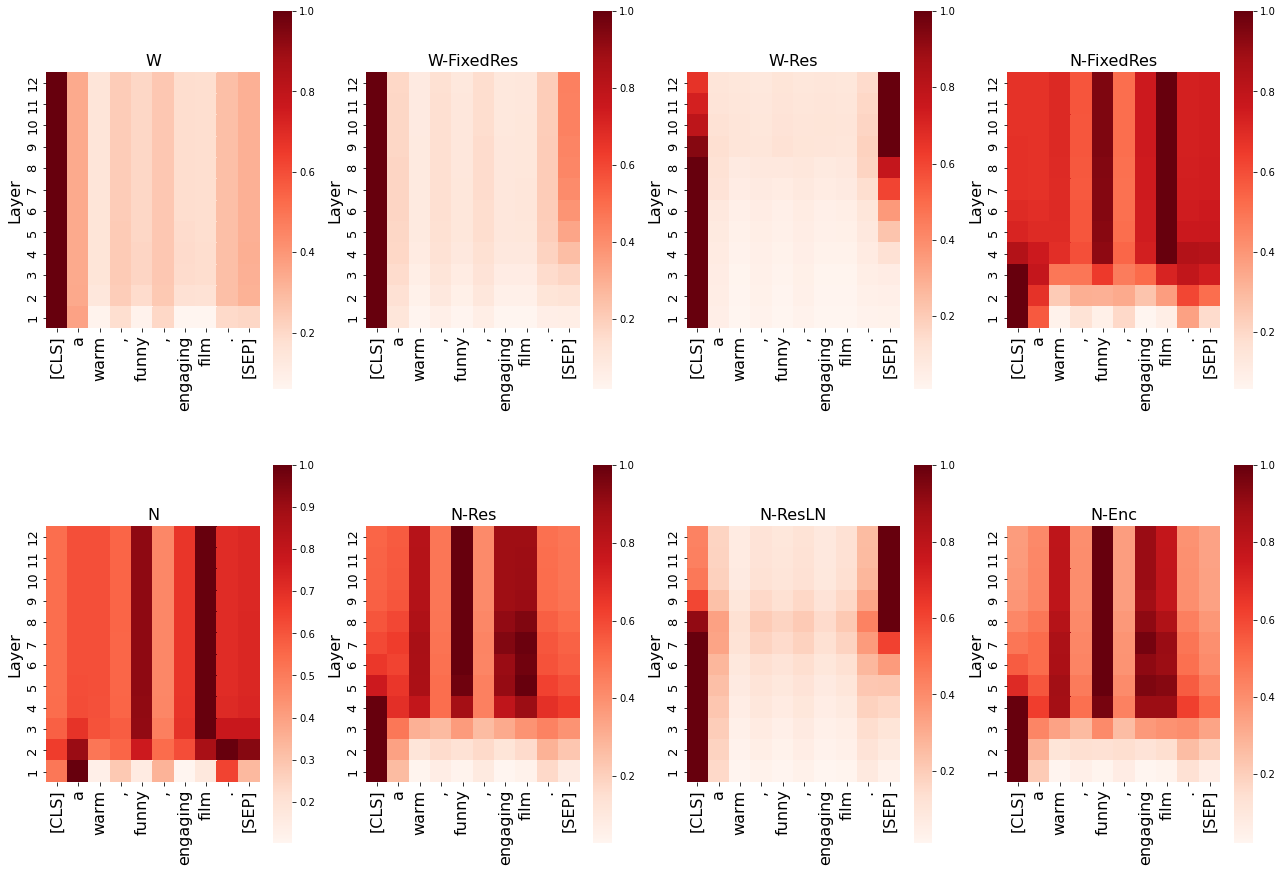

In [27]:
### 12 Layers in One (Just CLS)
import matplotlib.backends.backend_pdf

def plot_flow_heatmaps_cls(idx, specific_method=None):
    encoded = encoder_func(idx)
    tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    if specific_method is None:
        plt.figure(figsize=(22, 17))
    else:
        plt.figure(figsize=(6, 8))
    c = 1
    for key in attention_flows.keys():
        # N-Enc, N-Res
        if specific_method is not None and key != specific_method:
            continue
        if specific_method is None:
            plt.subplot(2, 4, c)
            c += 1
        else:
            plt.subplot(1, 1, c)
        norm_cls = attention_flows[key][idx][:, 0, :]
        norm_cls = np.flip(norm_cls, axis=0)
        row_sums = norm_cls.max(axis=1)
        norm_cls = norm_cls / row_sums[:, np.newaxis]
        
        df = pd.DataFrame(norm_cls, columns=tokenized_text, index=range(12, 0, -1))
        sns.heatmap(df,cmap="Reds",square=True)
        plt.title(key, fontsize=16)
        plt.ylabel("Layer", fontsize=16)
        plt.xticks(rotation = 90, fontsize=16)
        plt.yticks(fontsize=13)
        plt.gcf().subplots_adjust(bottom=0.2)
        
# 320, 493, 599, 746
idx = 311
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{config['DATASET']}_{idx}_rollout_cls.pdf")
# plot_flow_heatmaps_cls(idx, specific_method="N-Enc")
plot_flow_heatmaps_cls(idx, specific_method=None)
fig.tight_layout()
plt.savefig(pdf, format='pdf')
pdf.close()


# for i in range(800):
#     test_idx = i
#     encoded = encoder_func(test_idx)
#     tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
#     if 5 < len(tokenized_text) < 12 and "#" not in "".join(tokenized_text):
#         print("idx =", i)
#         plot_flow_heatmaps_cls(test_idx, specific_method="N-Res")
#         plt.show()

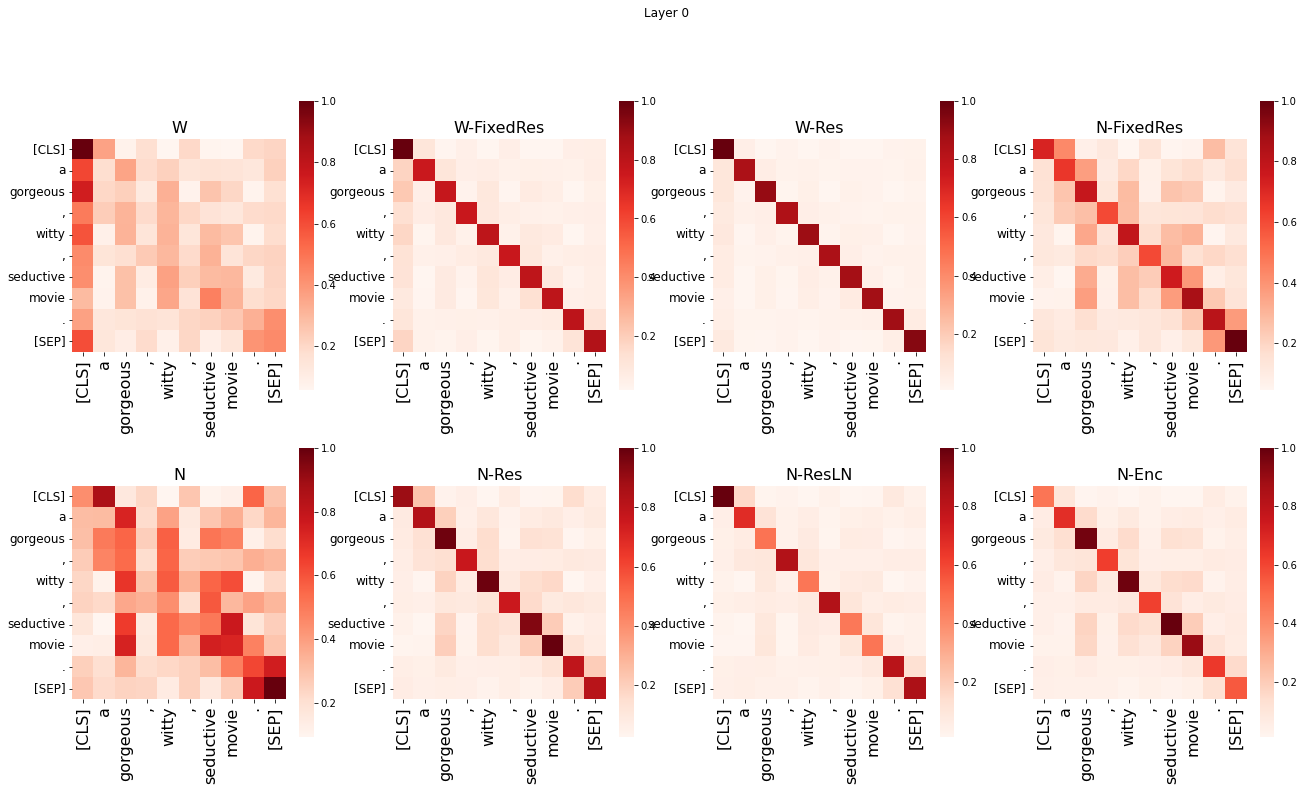

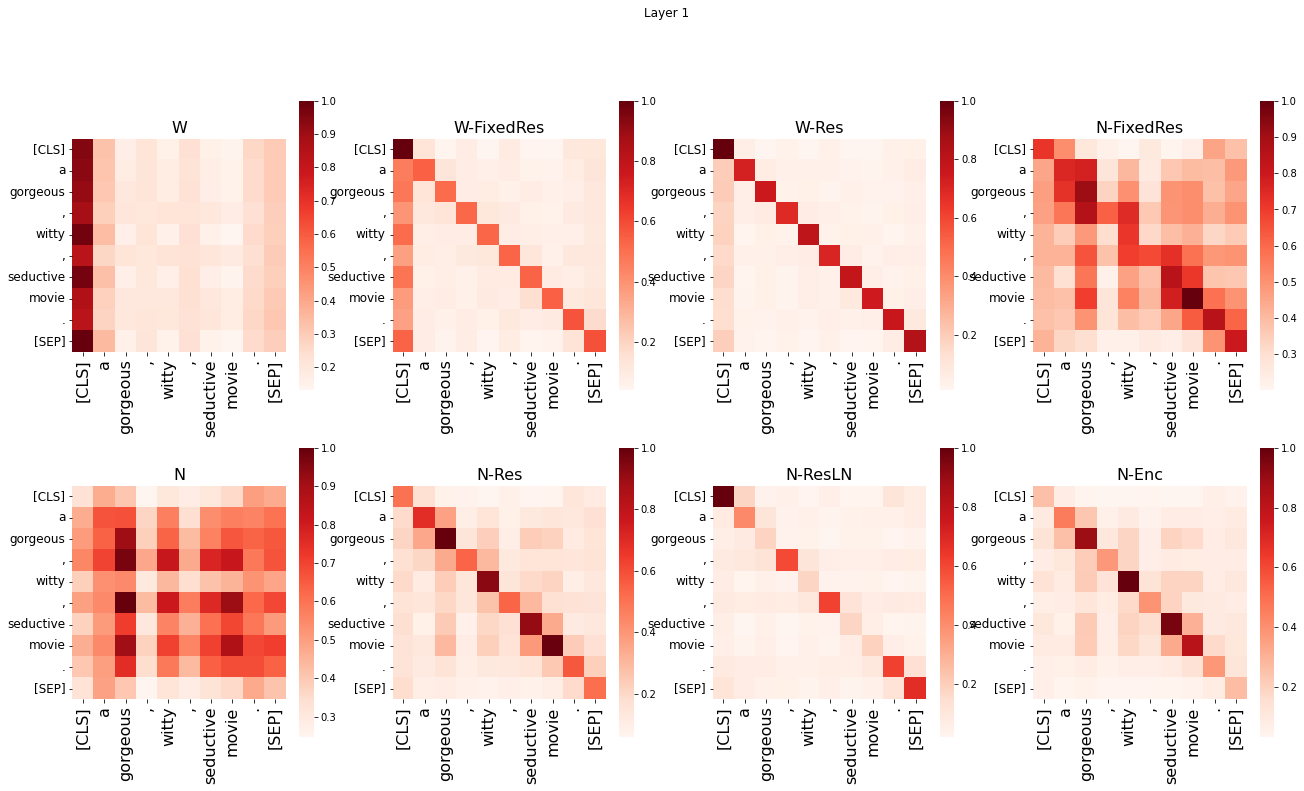

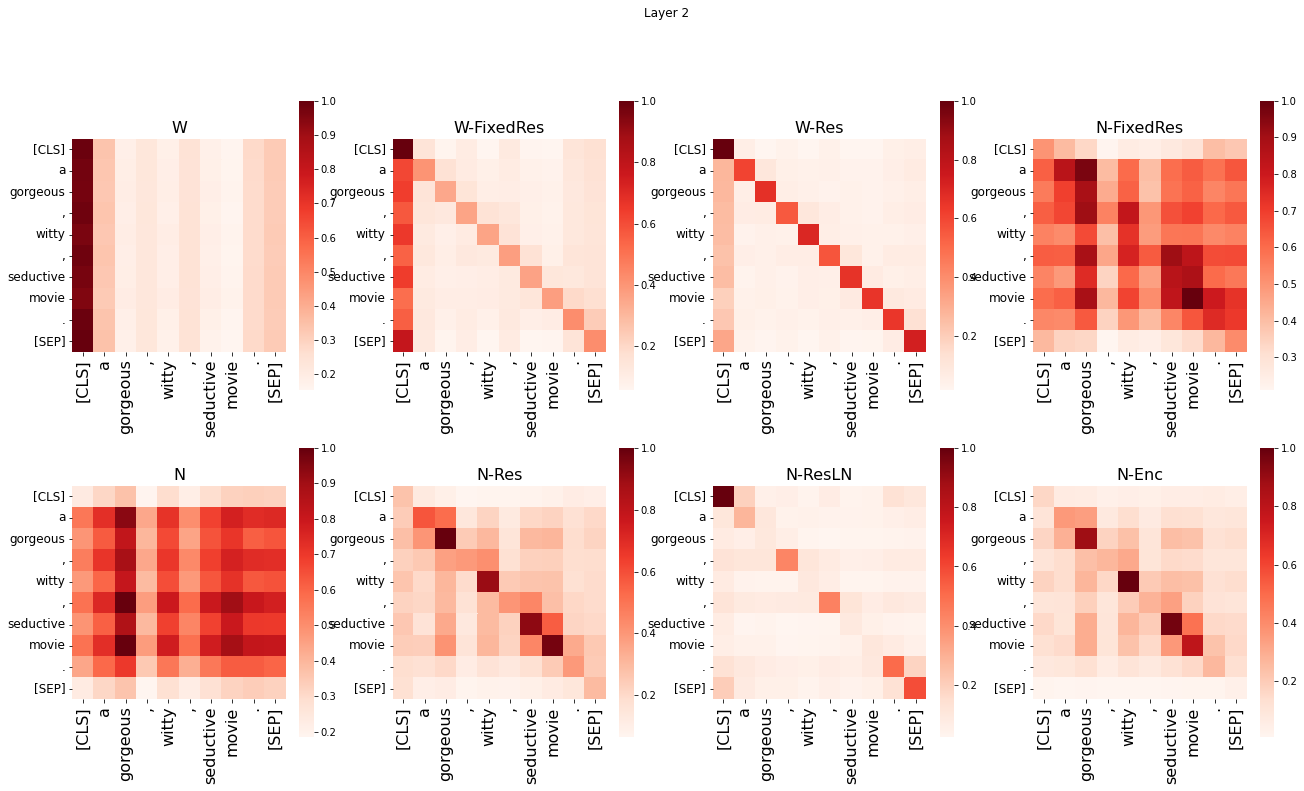

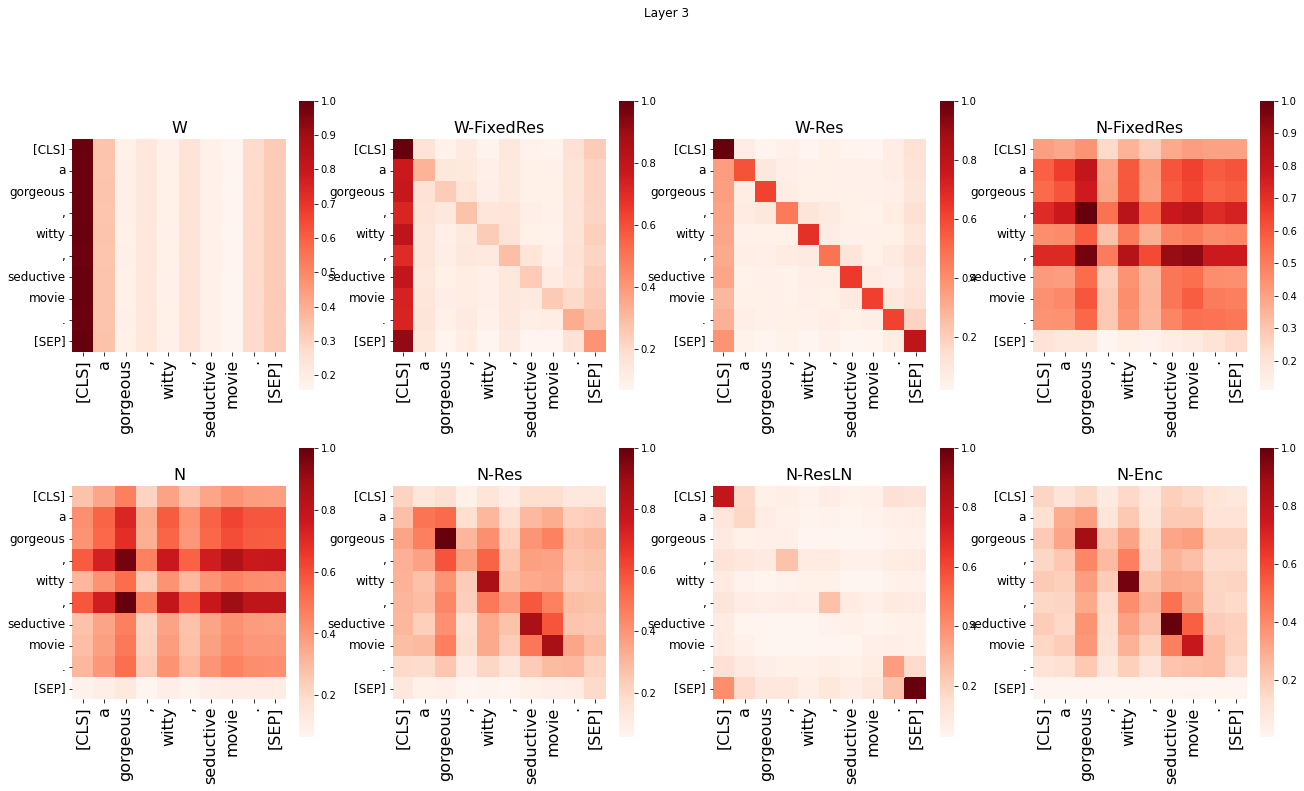

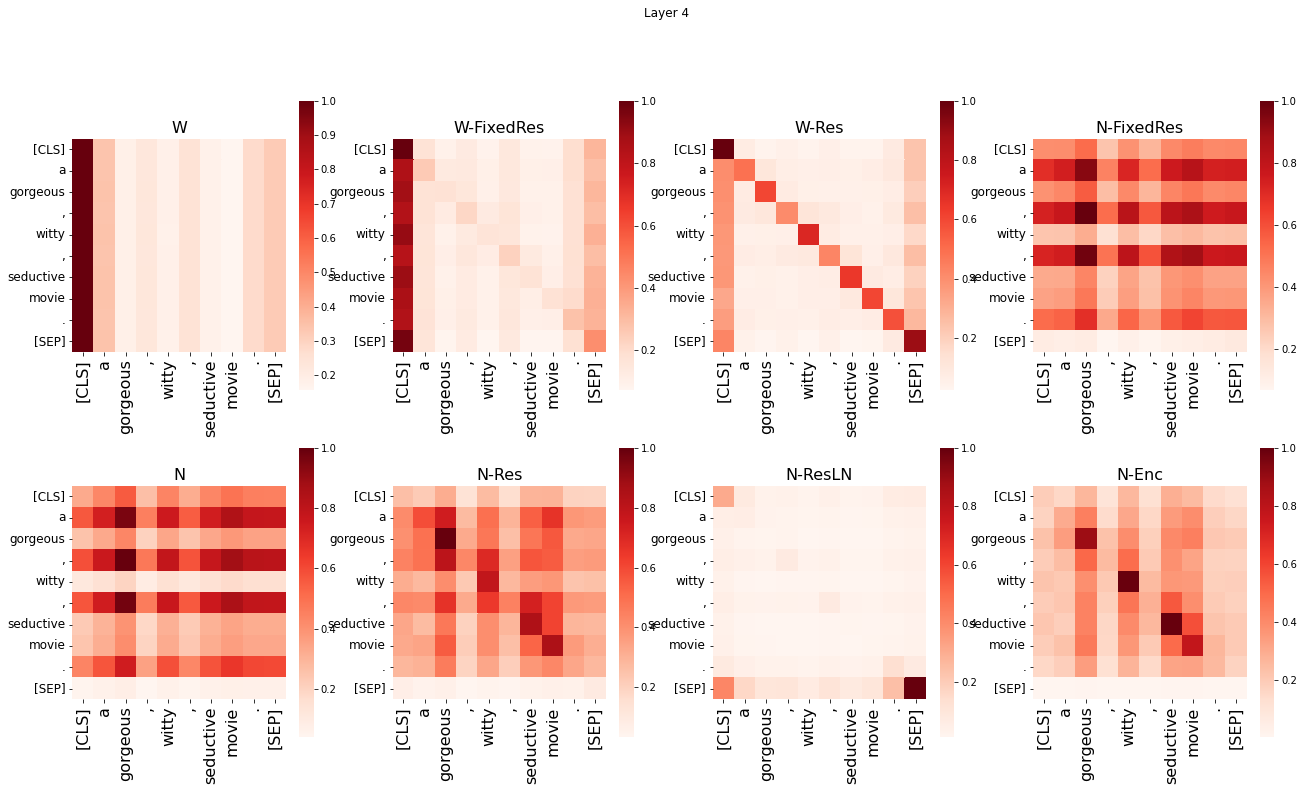

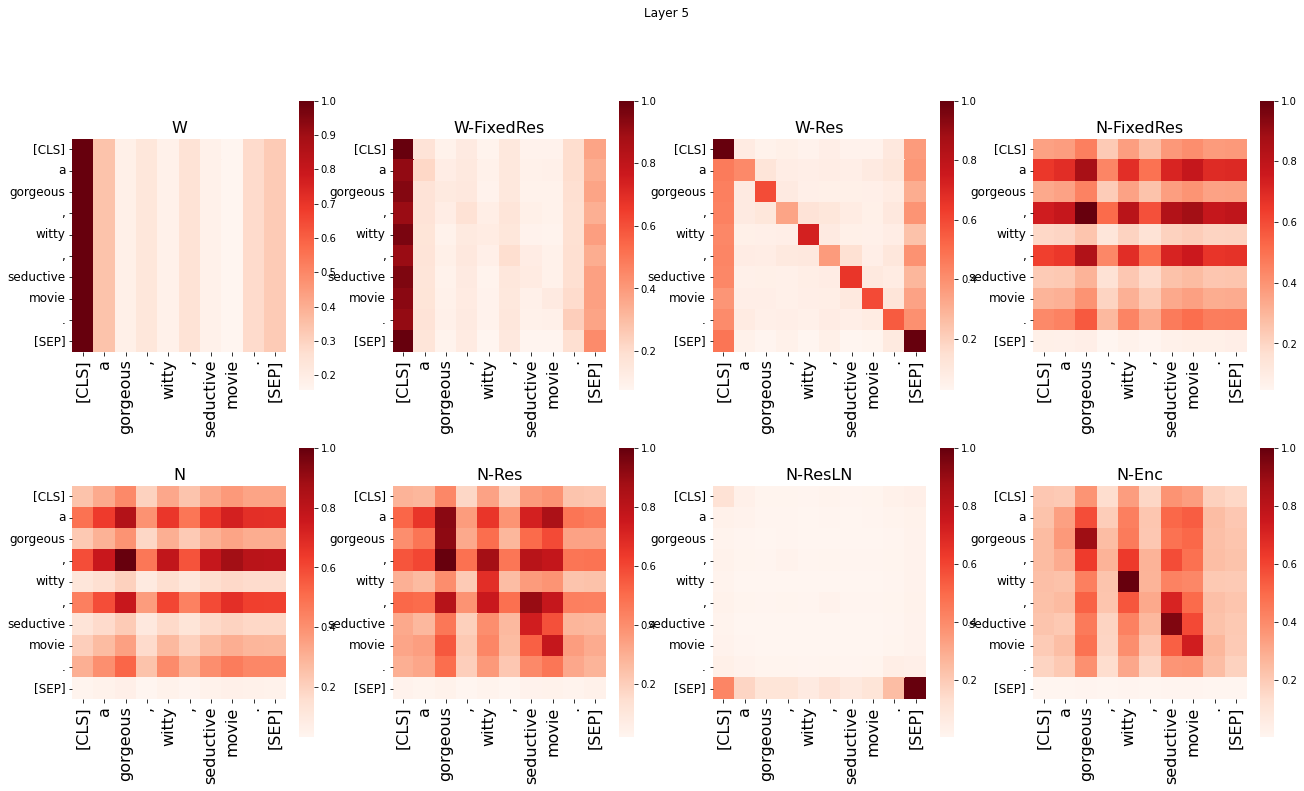

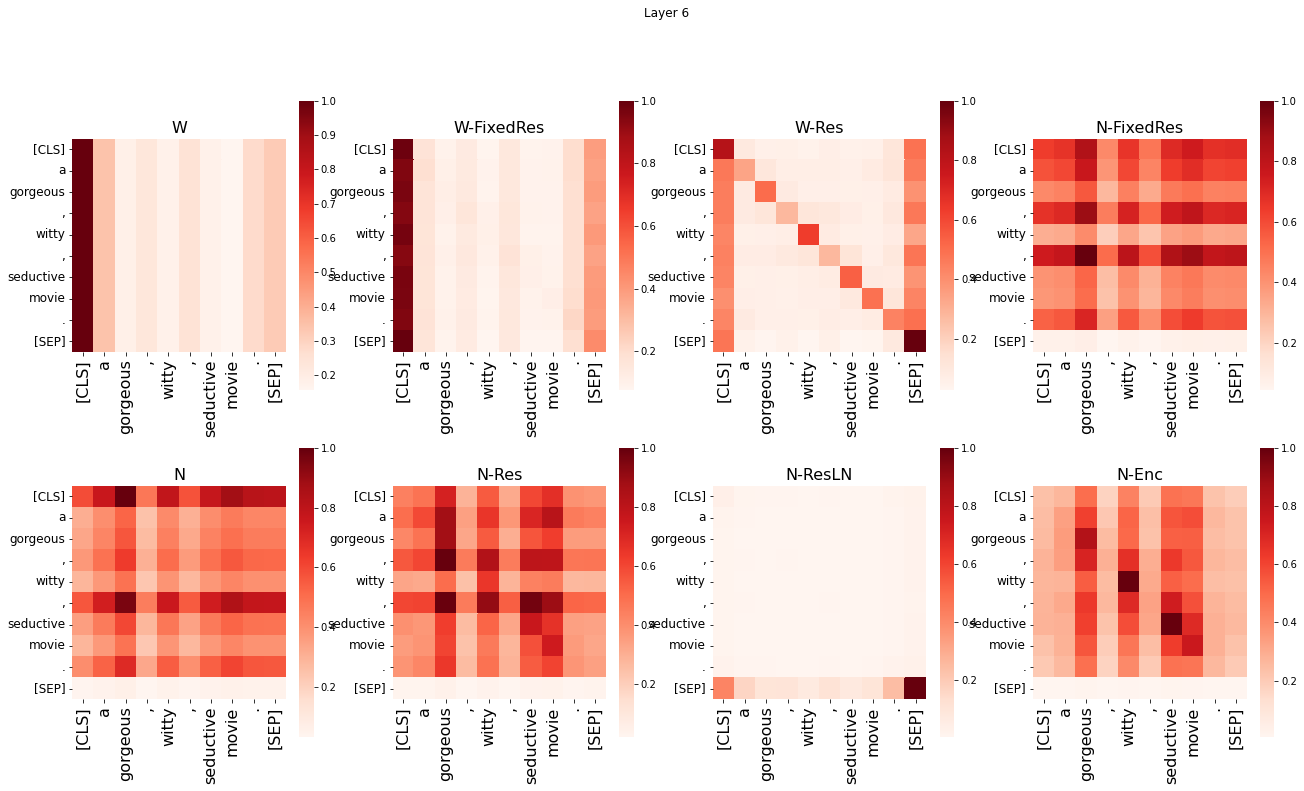

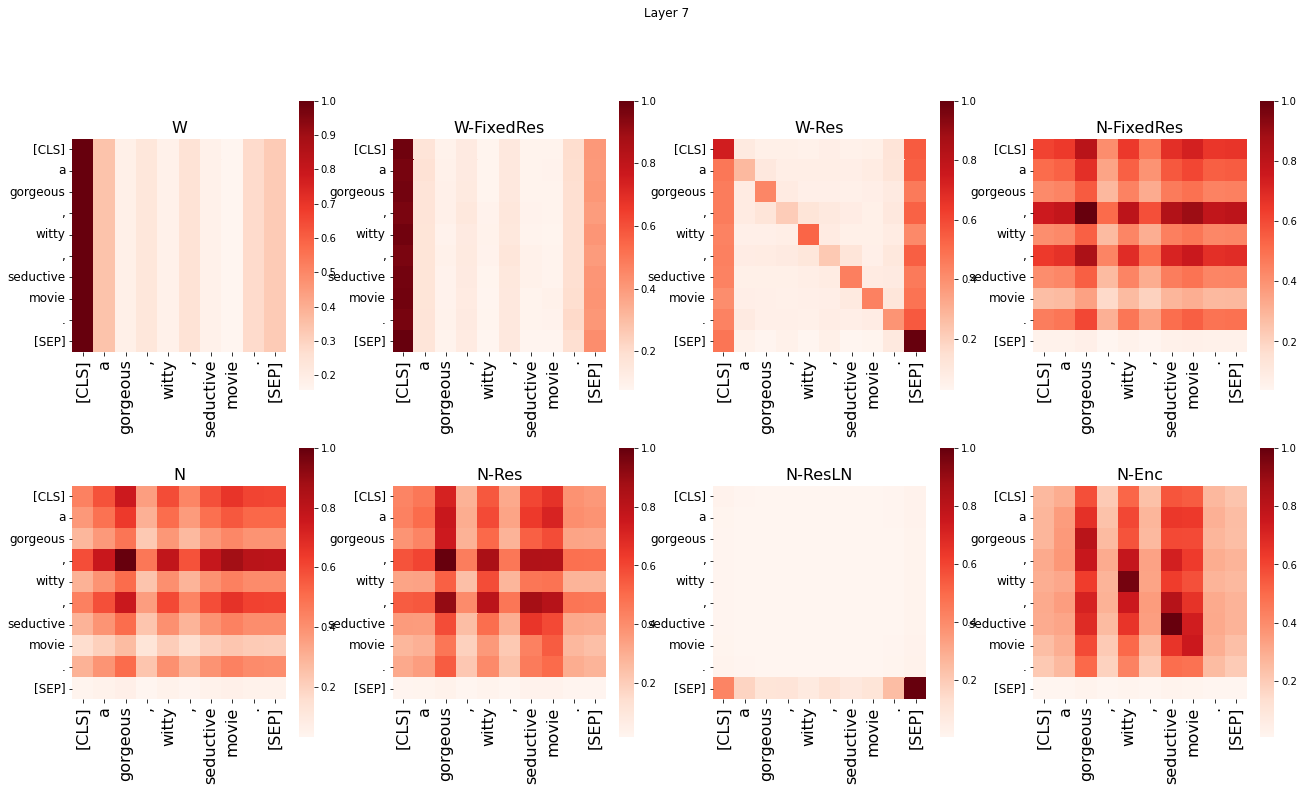

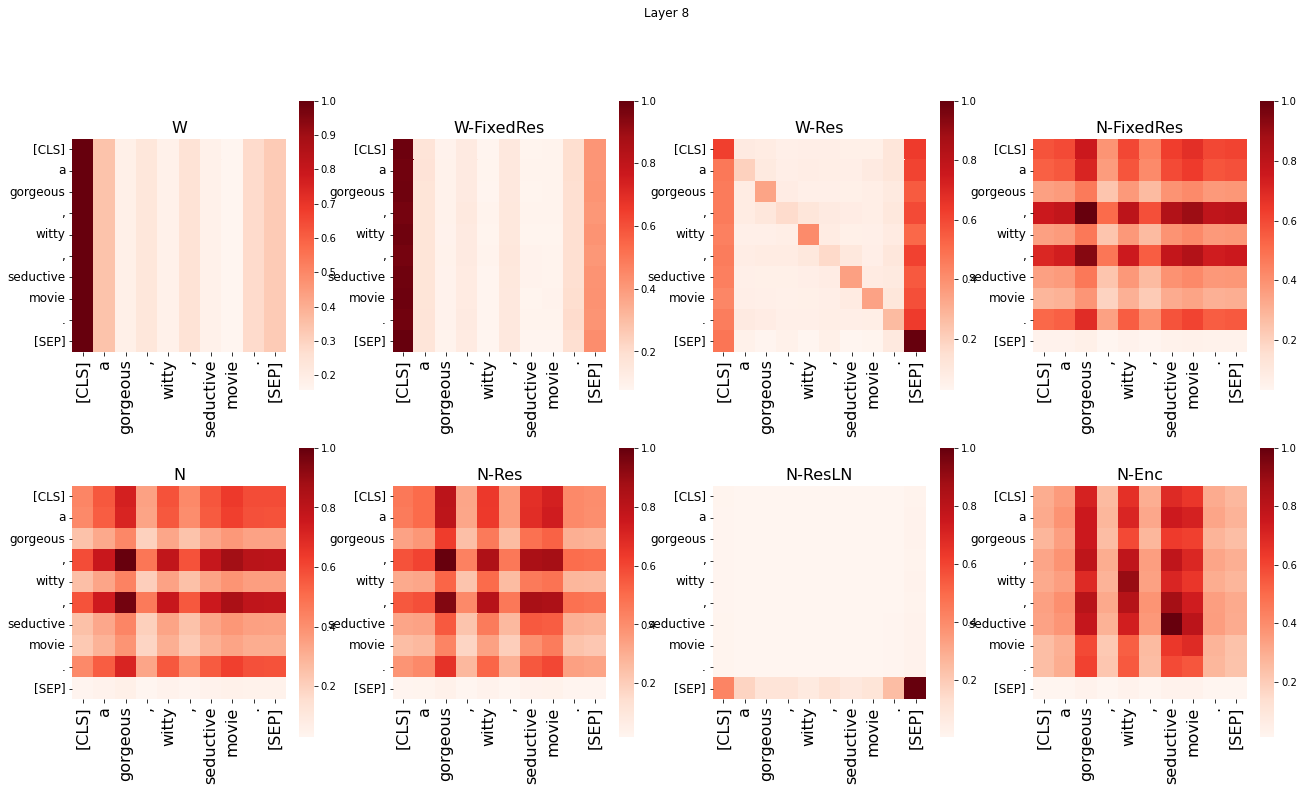

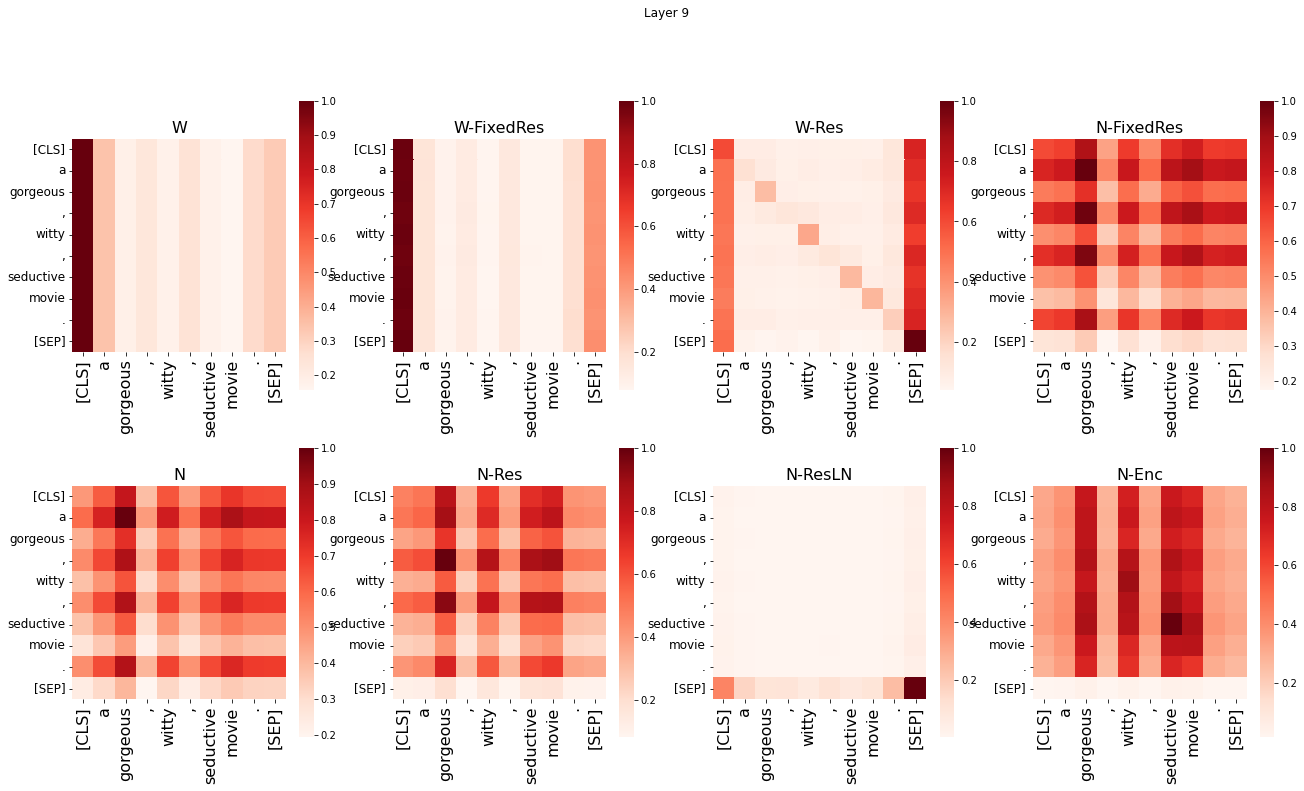

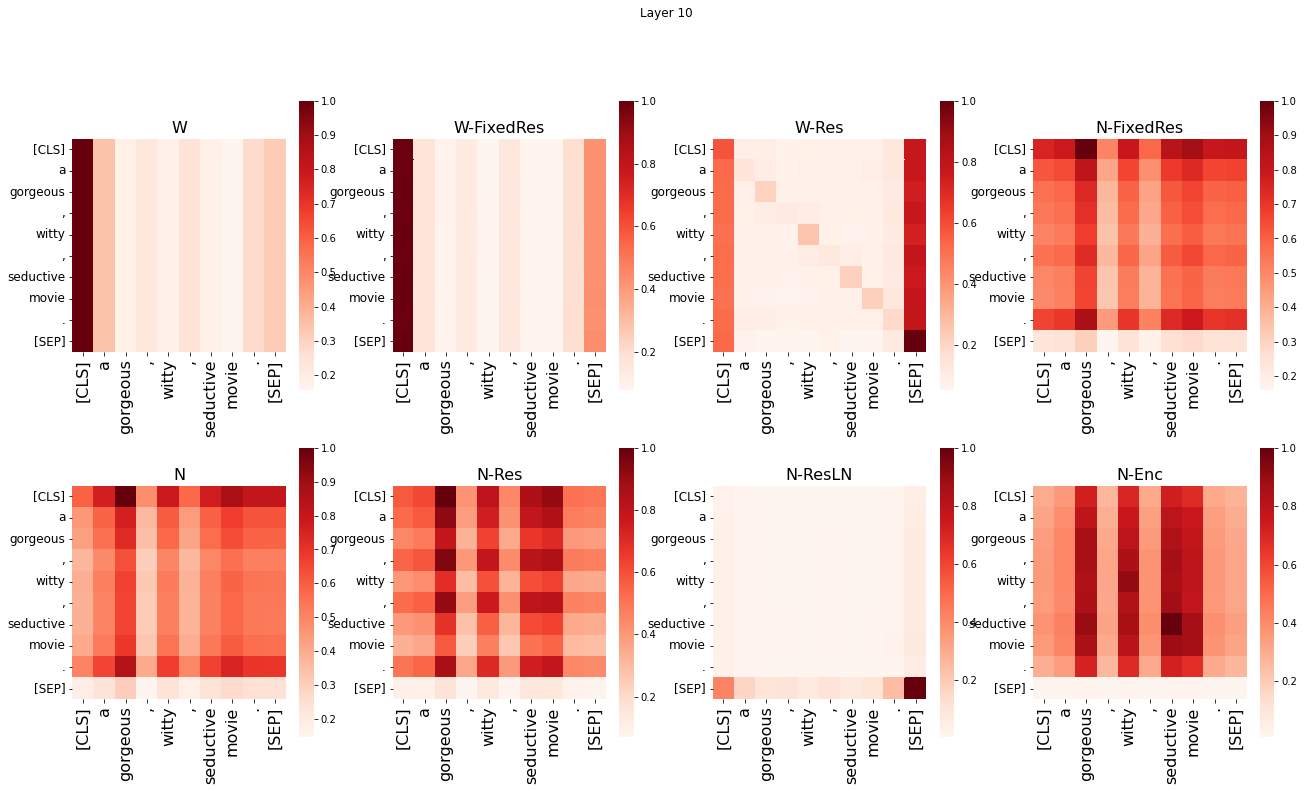

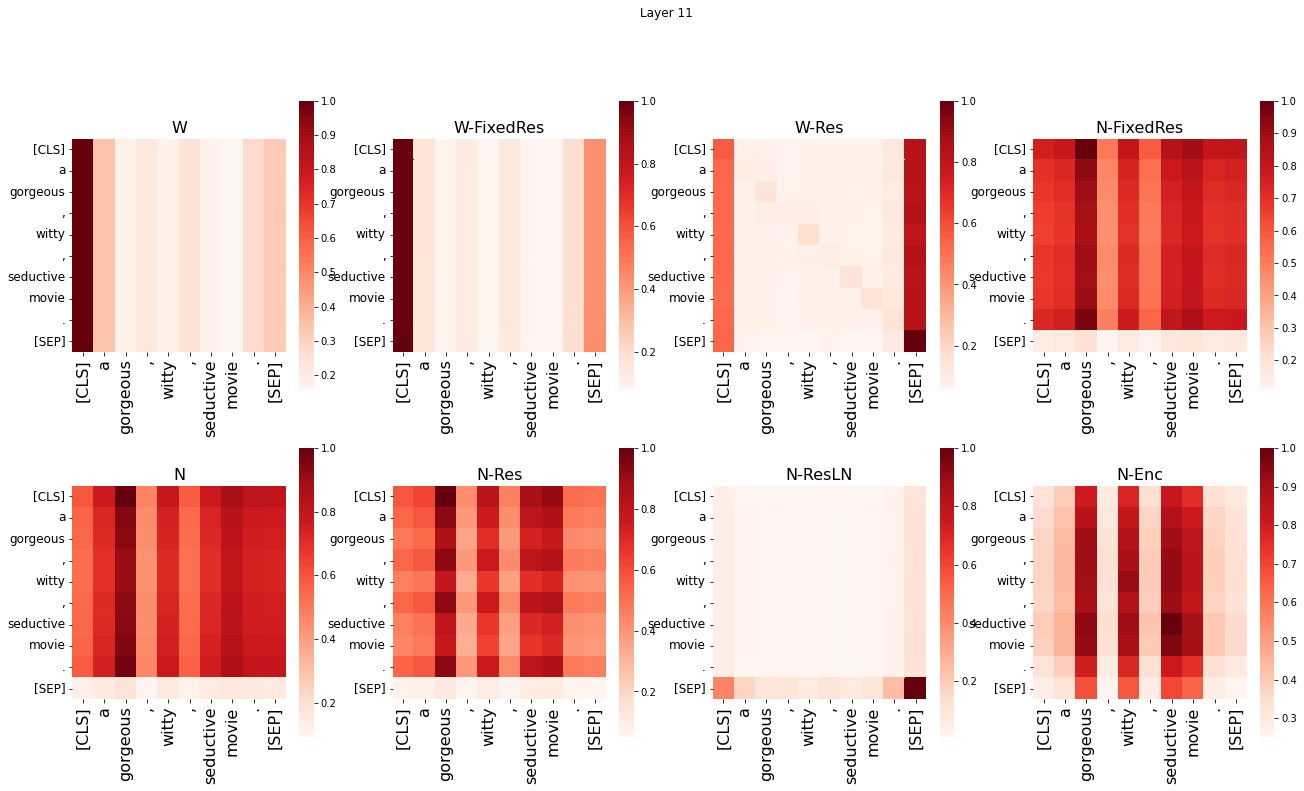

In [29]:
import matplotlib.backends.backend_pdf

def plot_flow_heatmaps(idx, layer=-1):
    encoded = encoder_func(idx)
    tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    plt.figure(figsize=(22, 13))
    c = 1
    for key in attention_flows.keys():
        plt.subplot(2, 4, c)
        c += 1
        norm = attention_flows[key][idx][layer] / np.max(attention_flows[key][idx][layer])
        plot_heatmap(norm, tokenized_text, key)
        plt.xticks(rotation = 90, fontsize=16)
        plt.title(key, fontsize=16)
        plt.yticks(rotation = 0, fontsize=16)
        plt.yticks(fontsize=12)
        

# for i in range(800):
#     test_idx = i
#     encoded = encoder_func(test_idx)
#     tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
#     if 2 < len(tokenized_text) < 5:
#         print("idx =", i)
#         plot_flow_heatmaps(test_idx)
#         plt.show()

# pdf = matplotlib.backends.backend_pdf.PdfPages(f"{config['DATASET']}_{idx}_rollout12_tokens.pdf")
# plot_flow_heatmaps(idx=112)
# fig.tight_layout()
# plt.savefig(pdf, format='pdf')
# pdf.close()

pdf = matplotlib.backends.backend_pdf.PdfPages(f"{config['DATASET']}_flow_aggregate_layers.pdf")
for layer in range(len(attention_flows["W"][0])):
    plot_flow_heatmaps(idx=32, layer=layer)
    plt.suptitle(f"Layer {layer}", fontsize=12)
    plt.savefig(pdf, format='pdf')
pdf.close()

In [14]:
# attention_flows["attnresln_n"][0][-1]/1e19

### Attention in single layers (w/o flow)

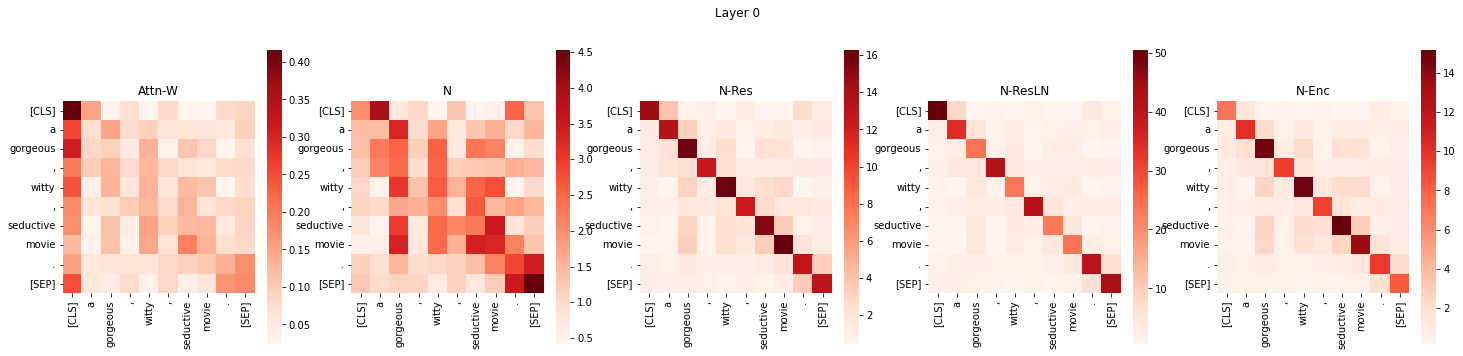

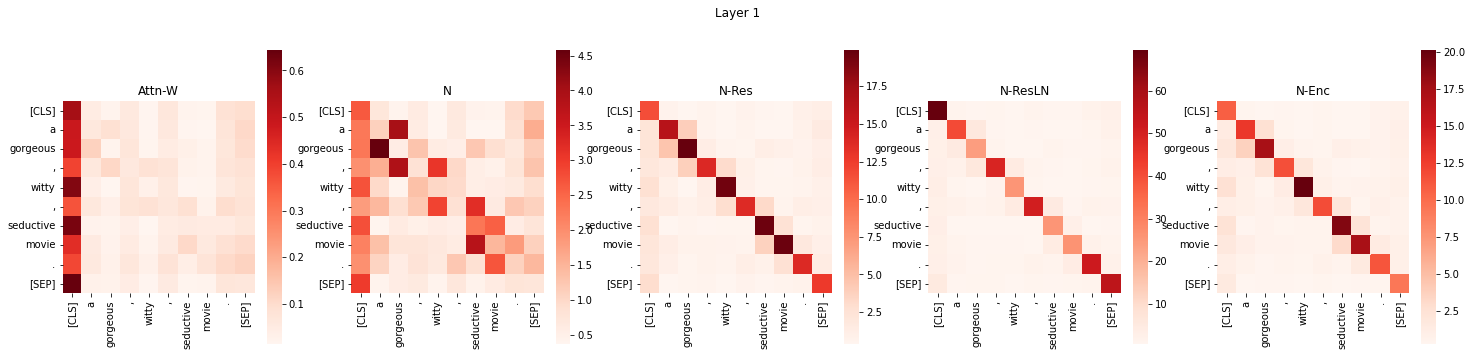

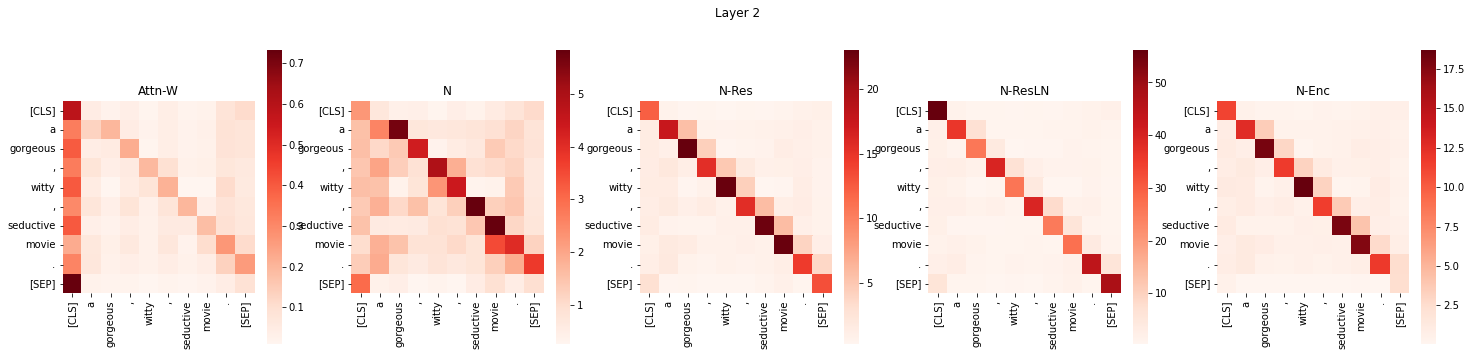

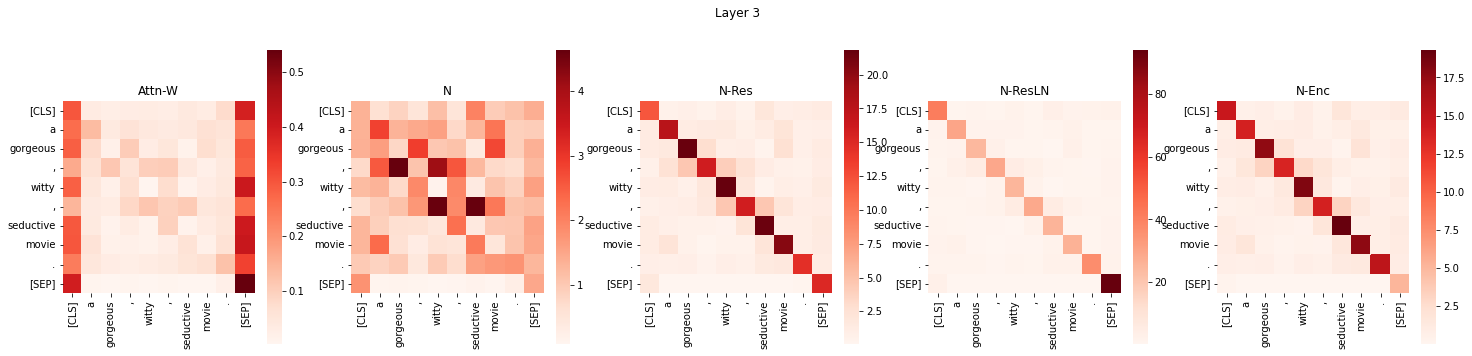

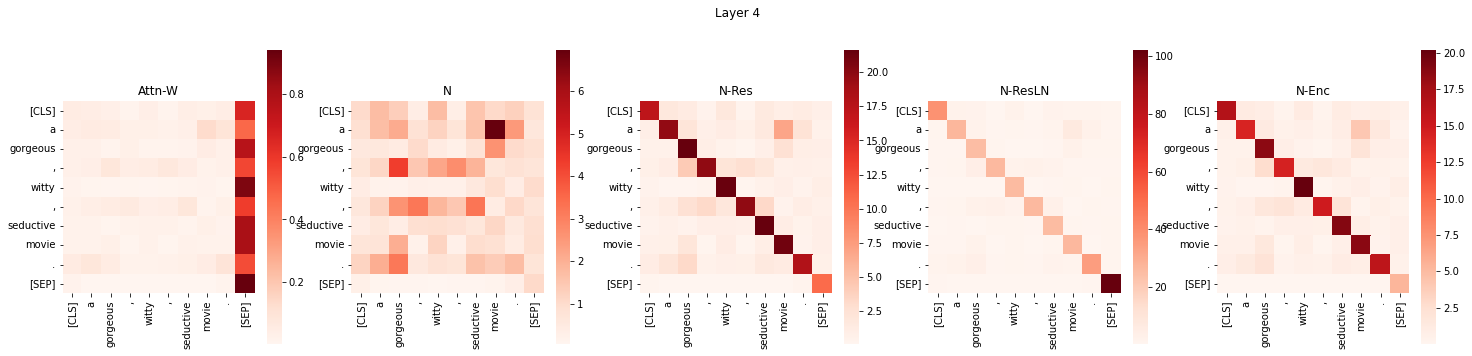

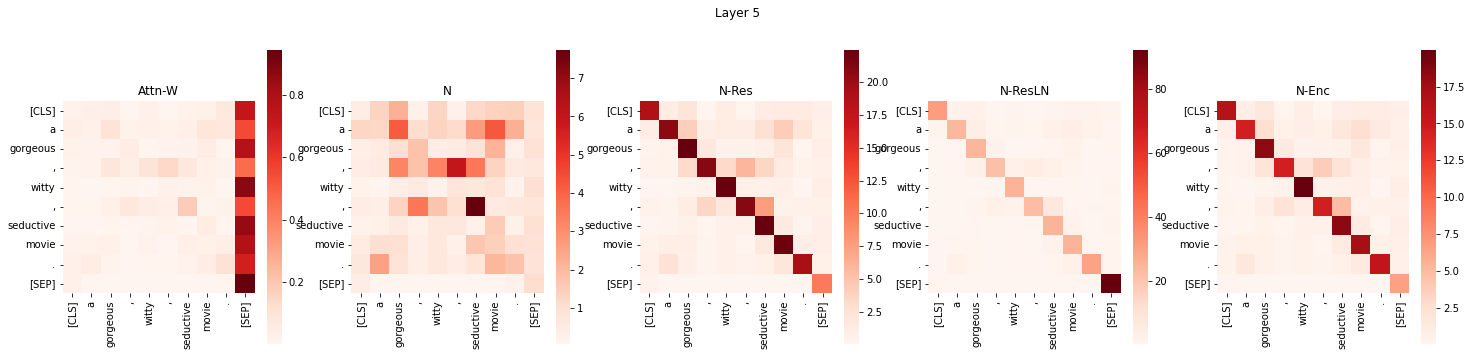

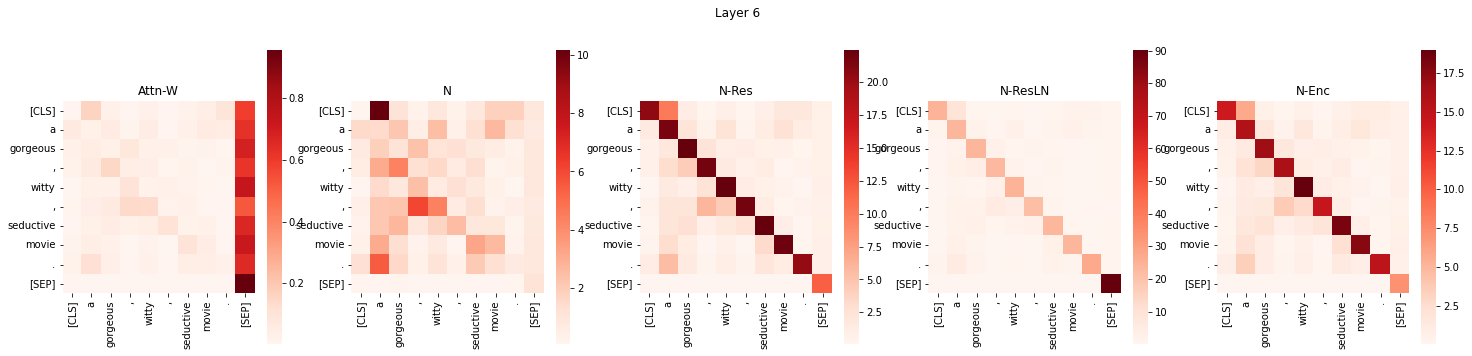

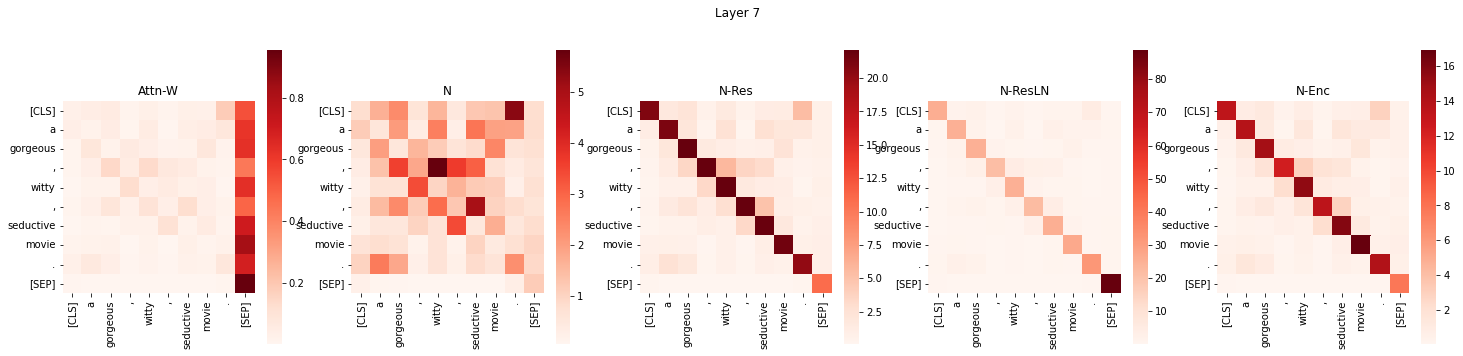

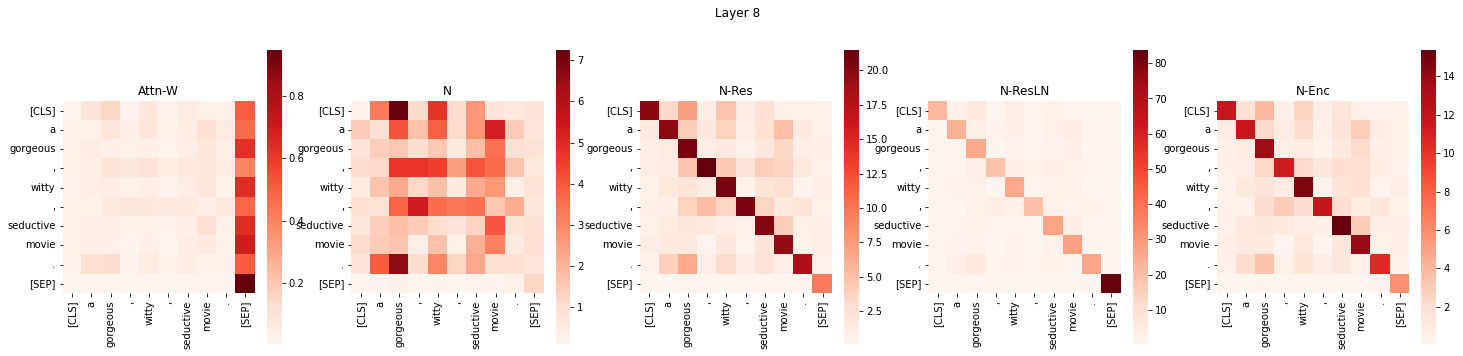

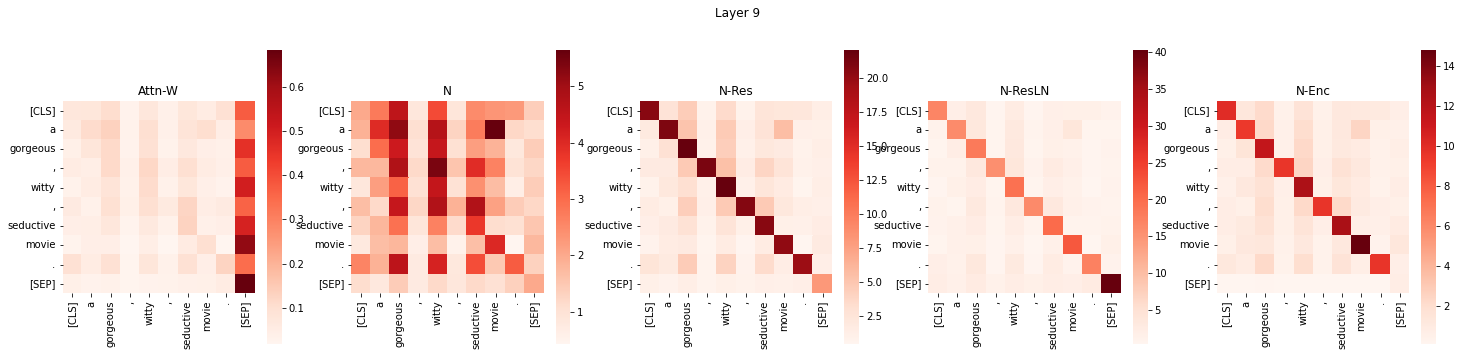

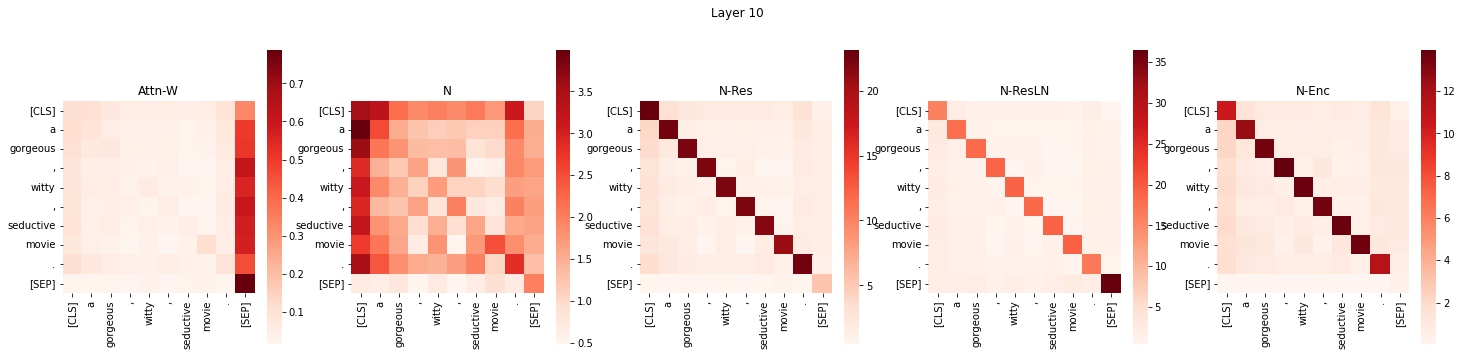

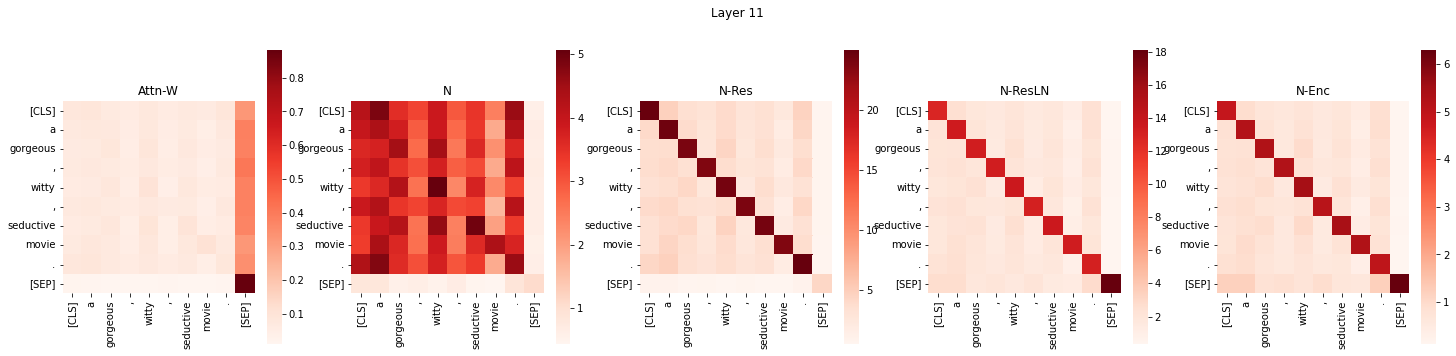

In [23]:
import matplotlib.backends.backend_pdf

def plot_layers_heatmap(idx, layer):
    encoded = encoder_func(idx)
    tokenized_text = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    plt.figure(figsize=(25, 6))
    # Plot Raw Attention
    plt.subplot(1, 5, 1)
    norm = raw_attentions[idx][layer]
    plot_heatmap(norm, tokenized_text, "Attn-W")
    # Plot Norm Attentions
    c = 2
    for key, value in ATTENTION_NORM_TYPES.items():
        plt.subplot(1, 5, c)
        c += 1
        norm = norms_list[value][idx][layer]
        plot_heatmap(norm, tokenized_text, key)

test_idx = 32
pdf = matplotlib.backends.backend_pdf.PdfPages("layers.pdf")
for layer in range(12):
    plot_layers_heatmap(test_idx, layer)
    plt.suptitle(f"Layer {layer}", fontsize=12)
    plt.savefig(pdf, format='pdf')
pdf.close()